In [151]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = '{:.0f}'.format

In [159]:
tournament = 'tournaments/rakuda_koukou_v0_tournament'
#tournament = ''
if not tournament:
    from elo import Bot, Referee, EloRanker, load_jsonl
    bots = [
        Bot('GPT3', 'answers/rakuda_koukou_v0/gpt3.jsonl'),
        Bot('Rinna 3.6B - PPO', 'answers/rakuda_koukou_v0/rinna-ppo.jsonl'),
        Bot('Rinna 3.6B - SFTv2', 'answers/rakuda_koukou_v0/rinna-sft.jsonl'),
        Bot('Rinna 3.6B', 'answers/rakuda_koukou_v0/rinna.jsonl'),
        Bot('Open Calm 7B - Stormy', 'answers/rakuda_koukou_v0/stormy.jsonl'),
        Bot('Open Calm 7B', 'answers/rakuda_koukou_v0/calm.jsonl')
    ]

    referee = Referee('matchups/rakuda_koukou_v0.jsonl',
                      'prompts/rakuda_reviewer.jsonl',
                      'prompts/rakuda_prompt_threeclass.jsonl',
                      max_tokens=1024,
                      model='gpt-3.5-turbo-0301')

    ranker = EloRanker(bots, 'questions/rakuda_koukou_v0.jsonl', referee, verbose=True)
    ranker.run_tournament(100)

    ranker.output_standings('tournaments/rakuda_koukou_v0_tournament_result.jsonl')    
    ranker.output_tournament('tournaments/rakuda_koukou_v0_tournament.jsonl')

## The tournament standings

In [161]:
standings = pd.DataFrame(load_jsonl(tournament+'_result.jsonl'))
standings.head()

,model,elo,num_matches,lower,median,upper,error_y,error_y_minus
0,GPT3,1341,67,1255,1322,1378,57,67
1,Open Calm 7B,956,68,905,998,1090,92,93
2,Rinna 3.6B - SFTv2,946,66,856,943,1033,90,87
3,Rinna 3.6B - PPO,929,67,814,900,986,86,86
4,Open Calm 7B - Stormy,925,66,870,954,1044,89,85


## Dataframe containing all results

In [162]:
results = pd.DataFrame(load_jsonl(tournament+'.jsonl'))
results.head(1)

,bot1,bot2,prematch_elo1,prematch_elo2,question,question_id,response1,response2,referee_comments,score,postmatch_elo1,postmatch_elo2
0,Rinna 3.6B - PPO,GPT3,1000,1000,北海道の主要な都市5つを挙げ、それぞれの地理的特徴について簡単に説明してください。,27,もちろんです。北海道の主要都市には、札幌、函館、小樽、釧路、帯広があります。これらの地域は、...,はい、北海道の主要な都市5つは、札幌市、旭川市、帯広市、函館市、釧路市です。\n\n1. 札...,アシスタント1の回答は、地理的特徴についての詳細な説明がなく、情報が不足しているため、評価は...,2,984,1016


## Evolution across the tournament

In [163]:
import matplotlib.pyplot as plt 
elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result['bot1'] == bot:
            bot_elos.append(result['postmatch_elo1'])
        elif result['bot2'] == bot:
            bot_elos.append(result['postmatch_elo2'])
        else:
            pass
    elos.update({bot:bot_elos})

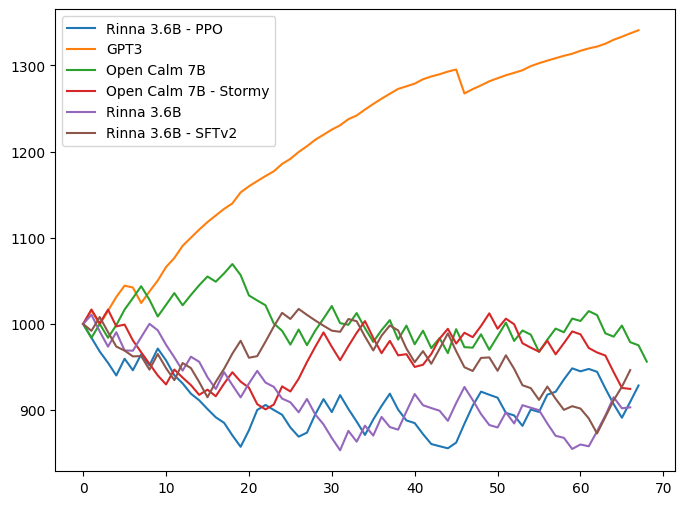

In [167]:
fig, ax = plt.subplots(figsize=(8, 6))
for k,v in elos.items():
    ax.plot(v, label=k)
ax.legend(loc='upper left')
ax.set_xlabel('Number of matches played')
ax.set_ylabel('Elo score')

## Results distribution

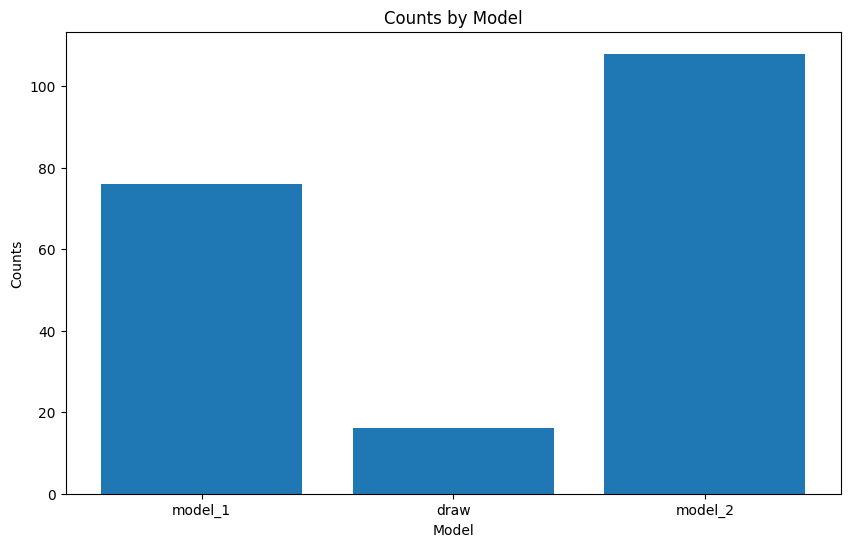

In [129]:
df = results["result"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
plt.figure(figsize=[10,6])
plt.bar(labels, df["count"])
plt.xlabel('Model')
plt.ylabel('Counts')
plt.title('Counts by Model')
plt.show()

## Head to head results

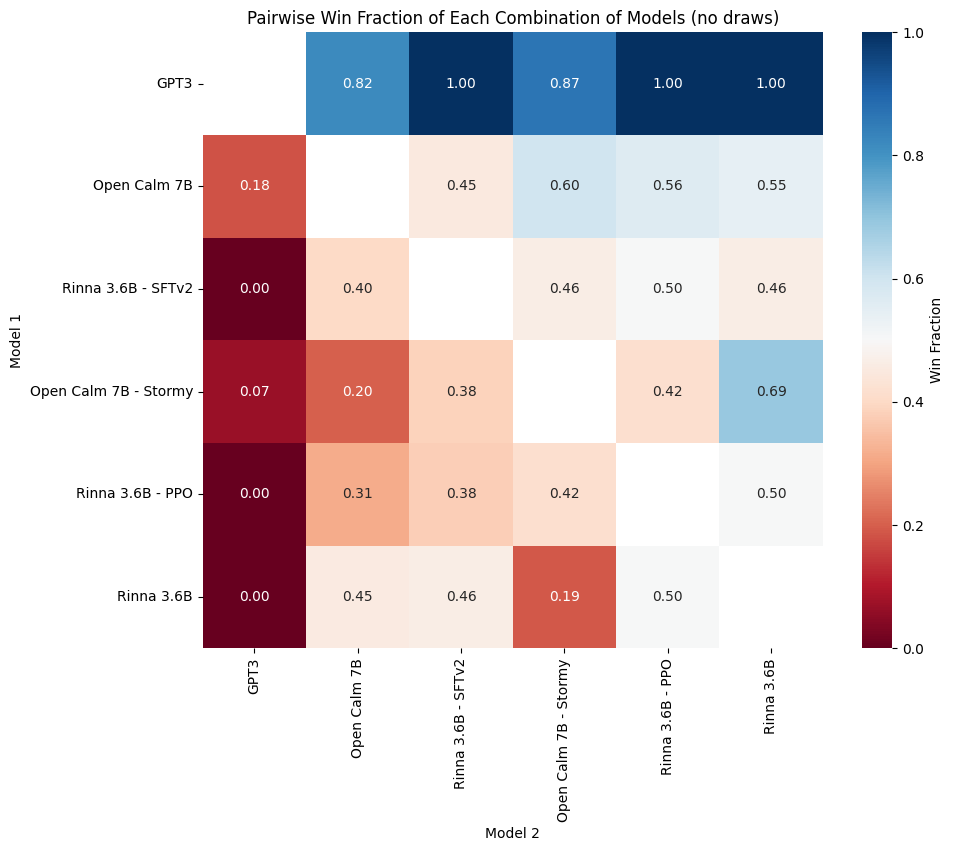

In [130]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["bot1"]).union(battles["bot2"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['result'] == 1], 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)
    
    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['result'] == 2], 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)
    
    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles, 
        index="bot1", columns="bot2", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B 
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) / 
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(row_beats_col, annot=True, fmt=".2f", cmap='RdBu', cbar_kws={'label': 'Win Fraction'})
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    #plt.savefig("pairwise_win_fraction.png")
    plt.show()

visualize_pairwise_win_fraction(results, title="Pairwise Win Fraction of Each Combination of Models (no draws)")

## Confirm elo computation was performed properly

In [131]:
from collections import defaultdict

def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)
 
    for rd, model_a, model_b, win in battles[['bot1', 'bot2', 'result']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)
    
    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [132]:
assert(all([round(row['elo'],6) == round(compute_elo(results)[row['name']],6) for i,row in standings.iterrows()]))

In [133]:
compute_elo(results)

{'GPT3': 1340.8622034768562,
 'Open Calm 7B': 956.2763310215707,
 'Rinna 3.6B - SFTv2': 946.4030740486336,
 'Rinna 3.6B - PPO': 928.5836741551208,
 'Open Calm 7B - Stormy': 924.6442803469116,
 'Rinna 3.6B': 903.2304369509079}

# Predict win rate

In [134]:
def predict_win_rate(standings, K=32, SCALE=400, BASE=10, INIT_RATING=1000):
    names = sorted(list(standings['name']))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (1 + BASE ** ((standings.loc[standings['name'] == b, 'elo'].values[0] - standings.loc[standings['name'] == a, 'elo'].values[0]) / SCALE))
            wins[a][b] = ea
            wins[b][a] = 1 - ea
      
    data = {
        a: [wins[a][b] if a != b else np.NAN for b in names]
        for a in names
    }

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

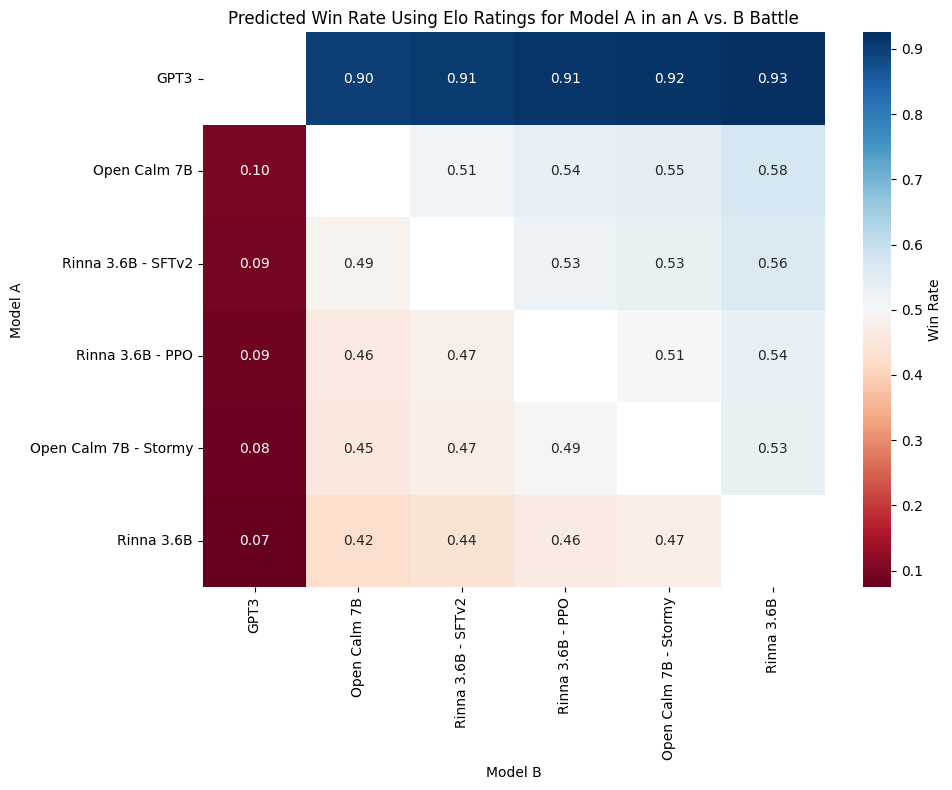

In [135]:
win_rate = predict_win_rate(standings)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(ordered_win_rate, annot=True, fmt=".2f", cmap='RdBu', cbar_kws={'label': 'Win Rate'})
plt.title('Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Compute Bootstrap Confidence Intervals for Elo Scores

The previous linear update method may be sensitive to battle orders. Here we use bootstrap to estimate the confidence intervals

In [136]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]

BOOTSTRAP_ROUNDS = 10000

bootstrap_elo_lu = get_bootstrap_result(results, compute_elo, BOOTSTRAP_ROUNDS)
bootstrap_elo_lu

bootstrap: 100%|██████████| 10000/10000 [00:11<00:00, 901.18it/s]


,GPT3,Open Calm 7B,Open Calm 7B - Stormy,Rinna 3.6B - SFTv2,Rinna 3.6B - PPO,Rinna 3.6B
0,1362,941,966,849,927,955
1,1277,1025,942,960,884,912
2,1333,1057,922,881,896,911
3,1293,1027,885,988,899,907
4,1322,1028,935,969,867,879
...,...,...,...,...,...,...
9995,1364,951,877,895,970,942
9996,1272,1050,964,876,903,935
9997,1339,1012,962,972,835,880
9998,1325,1019,979,936,883,858


In [137]:
bootstrap_elo = pd.DataFrame(dict(
    lower = bootstrap_elo_lu.quantile(.025),
    median = bootstrap_elo_lu.quantile(.5),
    upper = bootstrap_elo_lu.quantile(.975))).reset_index().rename(columns={"index": "model"}).sort_values("median", ascending=False)
bootstrap_elo['error_y'] = bootstrap_elo['upper'] - bootstrap_elo["median"]
bootstrap_elo['error_y_minus'] = bootstrap_elo['median'] - bootstrap_elo["lower"]
bootstrap_elo['median_rounded'] = np.round(bootstrap_elo['median'], 2)
    

In [148]:
bootstrap_elo

,model,lower,median,upper,error_y,error_y_minus,median_rounded
0,GPT3,1255,1323,1377,55,68,1323
1,Open Calm 7B,902,997,1090,93,95,997
2,Open Calm 7B - Stormy,868,953,1041,88,85,953
3,Rinna 3.6B - SFTv2,854,943,1031,89,89,943
4,Rinna 3.6B - PPO,813,900,988,88,87,900
5,Rinna 3.6B,796,885,976,91,89,885


In [149]:
standings

,model,elo,num_matches
0,GPT3,1341,67
1,Open Calm 7B,956,68
2,Rinna 3.6B - SFTv2,946,66
3,Rinna 3.6B - PPO,929,67
4,Open Calm 7B - Stormy,925,66
5,Rinna 3.6B,903,66


In [150]:
standings.merge(bootstrap_elo)

,model,elo,num_matches,lower,median,upper,error_y,error_y_minus,median_rounded
0,GPT3,1341,67,1255,1323,1377,55,68,1323
1,Open Calm 7B,956,68,902,997,1090,93,95,997
2,Rinna 3.6B - SFTv2,946,66,854,943,1031,89,89,943
3,Rinna 3.6B - PPO,929,67,813,900,988,88,87,900
4,Open Calm 7B - Stormy,925,66,868,953,1041,88,85,953
5,Rinna 3.6B,903,66,796,885,976,91,89,885


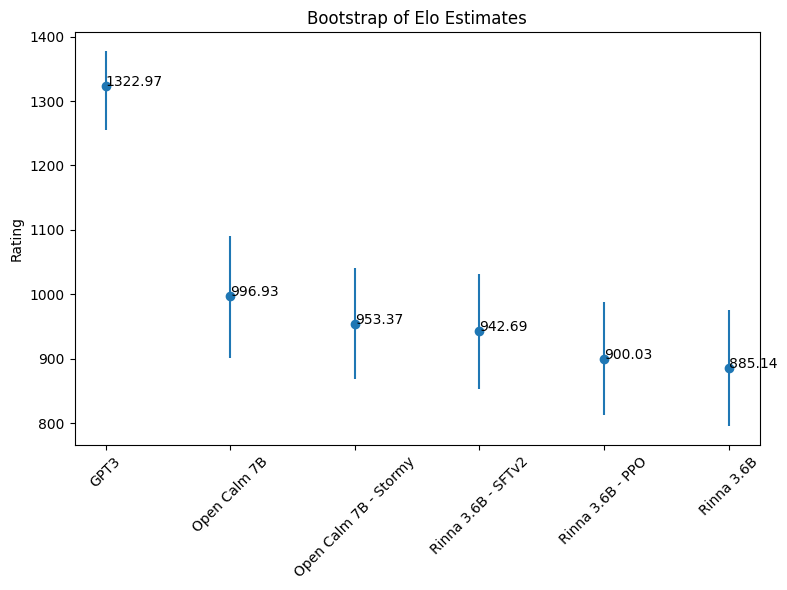

In [140]:
plt.figure(figsize=(8, 6))
plt.errorbar(bootstrap_elo['model'], bootstrap_elo['median'], yerr=[bootstrap_elo['error_y_minus'], bootstrap_elo['error_y']], fmt='o')
for i, txt in enumerate(bootstrap_elo['median_rounded']):
    plt.annotate(txt, (bootstrap_elo['model'][i], bootstrap_elo['median'][i]))
plt.title( "Bootstrap of Elo Estimates")
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#plt.savefig('bootstrap_elo_estimates.png')
#plotly version
#     
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y", 
#                   error_y_minus="error_y_minus", text="median_rounded", 
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig


### Add bootstrap error estimate to time evolution plot

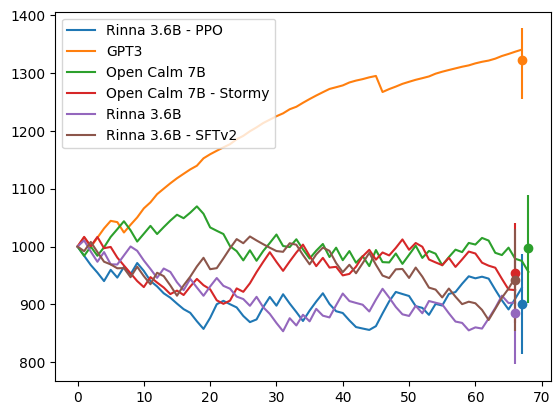

In [142]:
import matplotlib.pyplot as plt 

elos = {}
for bot in results.bot1.unique():
    bot_elos = [1000]
    for i, result in results.iterrows():
        if result['bot1'] == bot:
            bot_elos.append(result['postmatch_elo1'])
        elif result['bot2'] == bot:
            bot_elos.append(result['postmatch_elo2'])
        else:
            pass
    elos.update({bot:bot_elos})

bootstrap_elo = bootstrap_elo.set_index('model')
for k,v in elos.items():
    line = plt.plot(v, label=k)
    if k in bootstrap_elo.index:  # check if the model has bootstrap estimates
        # plt.errorbar(len(v) - 1, v[-1], 
        #              yerr=[[bootstrap_elo.loc[k, 'error_y_minus']], 
        #                    [bootstrap_elo.loc[k, 'error_y']]],
        #              fmt='o',color=line[0].get_color())
        plt.errorbar(len(v) - 1, bootstrap_elo.loc[k,'median'], 
                     yerr=[[bootstrap_elo.loc[k, 'error_y_minus']], 
                           [bootstrap_elo.loc[k, 'error_y']]],
                     fmt='o',color=line[0].get_color())
bootstrap_elo = bootstrap_elo.reset_index()
plt.legend()